![PyTorch Logo](https://github.com/pkorobov/deep-learning/blob/master/images/pytorch1.png?raw=1)

In [0]:
! python3 -m pip install tensorboardx tensorboard pretrainedmodels catalyst requests

In [0]:
# for colab
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
! pwd
import os
os.chdir("gdrive/My Drive/HW")

In [1]:
%matplotlib inline
%load_ext tensorboard

from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import torch
import torchvision
from torchvision.datasets import MNIST

from torch.utils.data import Dataset

from torchvision.datasets.folder import default_loader
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision.models import densenet121, densenet161, resnet101
from pretrainedmodels import dpn92
from torch.nn import BCEWithLogitsLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tensorboardX import SummaryWriter
import cv2
from PIL import Image

from albumentations import (
    Compose, OneOf, ToFloat, Resize, Normalize,
    HorizontalFlip, HueSaturationValue, RandomBrightness, RandomContrast,
    ShiftScaleRotate, RGBShift, RandomContrast, RandomSizedCrop
)

from albumentations.pytorch import ToTensor
import catalyst
from catalyst import utils
from catalyst.contrib.criterion import DiceLoss
from catalyst.dl.callbacks import DiceCallback, CriterionCallback, CriterionAggregatorCallback
from catalyst.dl import SupervisedRunner

from typing import Any, Mapping, Dict, List, Union
from sklearn.model_selection import train_test_split
import collections
from catalyst.utils import set_global_seed, prepare_cudnn
import random


SEED = 111

lz4 not available, disabling compression. To install lz4, run `pip install lz4`.
wandb not available, to install wandb, run `pip install wandb`.


We will use not only basic functionlaity of `pytorch` but also **`torchvision`** computer vision library.

In [0]:
!pip freeze 2>/dev/null | grep torch

torch==1.3.0+cu100
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.4.1+cu100


# Pytorch as a constructor

## Working with datasets

For data loading pytorch defines **`Dataset`** entity.

This abstract class is defined in `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
One should inherit `Dataset` and implement `__getitem__` and `__len__` nethods to create a new data source.

An example of such ancestor — `torchvision.datasets.ImageFolder`, which allows us to use imagenet-like dataset based on a directory with `./train/{class}` and `./val/{class}` sub-directories structure:

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Custom example — a dataset loading images with classes defined in some text file:

In [0]:
class TxtList(Dataset):
    def __init__(self, path, transform=None, loader=default_loader):
        with open(path) as fin:
            self.imgs = [s.strip().split() for s in fin.readlines()]

        print(f'=> Found {len(self.imgs)} entries in {path}')

        self.classes = sorted(set([_[1] for _ in self.imgs]))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        target = self.class_to_idx[target]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
!echo '/tmp/1.jpg\tcat' > /tmp/dataset.tsv
!echo '/tmp/2.jpg\tcat' >> /tmp/dataset.tsv
!echo '/tmp/3.jpg\tdog' >> /tmp/dataset.tsv
!echo '/tmp/4.jpg\tcat' >> /tmp/dataset.tsv

In [13]:
! cat /tmp/dataset.tsv

/tmp/1.jpg\tcat
/tmp/2.jpg\tcat
/tmp/3.jpg\tdog
/tmp/4.jpg\tcat


In [0]:
catdog = TxtList('/tmp/dataset.tsv')

In [0]:
catdog.classes

['cat', 'dog']

In [0]:
catdog.imgs

[['/tmp/1.jpg', 'cat'],
 ['/tmp/2.jpg', 'cat'],
 ['/tmp/3.jpg', 'dog'],
 ['/tmp/4.jpg', 'cat']]

In [0]:
len(catdog)

4

In [0]:
# FileNotFoundError
catdog[0]

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/1.jpg'

`torchvision` has another useful classes for using standard datasets: 
http://pytorch.org/docs/master/torchvision/datasets.html.

Some of them can be preloaded with built-in functionality, for example **MNIST**:

In [0]:
# ![ -d '/tmp/mnist/' ] && rm -r '/tmp/mnist/'

In [0]:
# ! [ -d '/tmp/mnist/' ]

In [0]:

%time mnist = MNIST('~/mnist/', train=True, download=False)

CPU times: user 6.04 ms, sys: 31.6 ms, total: 37.6 ms
Wall time: 55.1 ms


In [0]:
len(mnist)

60000

In [0]:
image, target = mnist[0]
print(target)

5


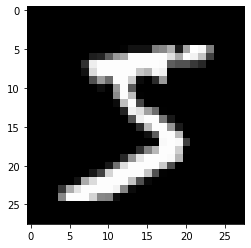

In [0]:
plt.imshow(np.array(image), 'gray')
plt.show()

## <font color='#cc6666'>Hometask!</font>

Implement **`UrlList`** dataset which costructor takes list of urls as a parameter.

In [0]:
from PIL import Image
import requests
from io import BytesIO

from typing import List


class UrlList(Dataset):
    def __init__(self, urls: List[str]):
        self.urls = urls

    def __getitem__(self, index):        
        url = self.urls[index]
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
     
    def __len__(self):
        return len(self.urls)

Demonstrate how it works with some examples:

In [0]:
instance = UrlList(["https://upload.wikimedia.org/wikipedia/commons/1/18/Vombatus_ursinus_-Maria_Island_National_Park.jpg",
                    "https://sun9-12.userapi.com/c845123/v845123199/19e5a4/dXrj5RkOV6s.jpg"])

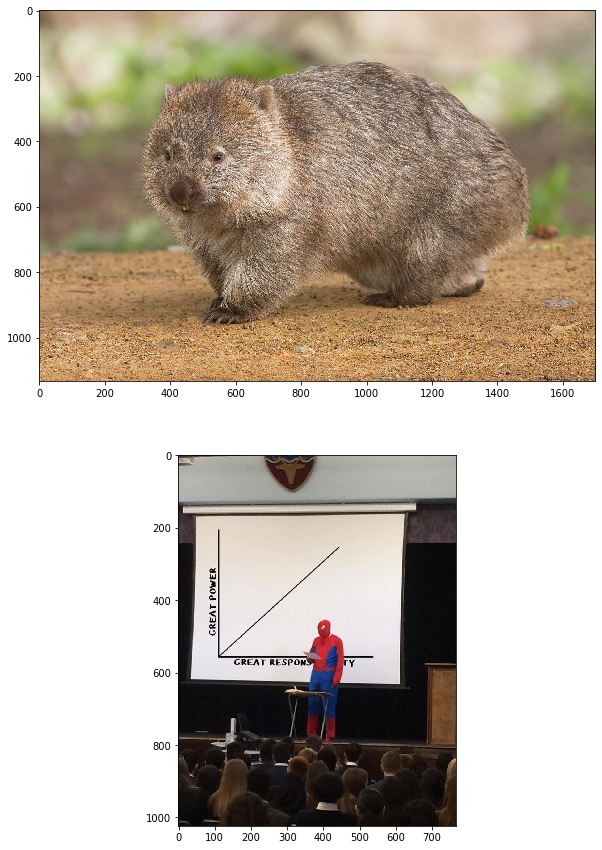

In [0]:
fig, ax = plt.subplots(2, figsize=(20, 15))
ax[0].imshow(instance[0])
ax[1].imshow(instance[1])

In [0]:
len(instance)

2

## Data transformation

In the example shown before and in built-in `ImageFolder` `__init__` methods has `transform` parameter (and `target_transform`).

They are used to transform images/targets loaded into predefined range and form.

There is `transforms` sub-module in `torchvision` library which has some examples of such transforms:

For example `transforms.ToTensor()` transforms uint8 `PIL` [0, 256)-domained images into [0, 1)-domained tensors.

In [0]:
to_tensor = transforms.ToTensor()

In [0]:
pil_image = mnist[0][0]
th_image = to_tensor(pil_image)
th_image.shape, th_image.min(), th_image.max()

(torch.Size([1, 28, 28]), tensor(0.), tensor(1.))

One can define `normalize` to implement a standard ImageNet preparation step:

In [0]:
pil_image

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

`transforms.Compose` is used to sequence several compositions as a whole:

In [0]:
crop_and_tensorize = transforms.Compose([
    transforms.CenterCrop(16),
    transforms.ToTensor(),
])

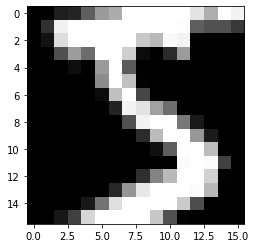

In [0]:
plt.imshow(crop_and_tensorize(pil_image)[0].numpy(), 'gray')
plt.show()

To define a custom transformer we should only implement `__call__` method its implementation:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

It is adviced to take a glance at http://pytorch.org/docs/master/torchvision/transforms.html for standard transformations overview.

## Optional reading

Another example of a good set of pre-defined transformations is [`albumentations`](https://github.com/albu/albumentations) library.

It supports not only image transformations but it can simultaniously transform its corresponding masks and bboxes.

One can also use [`imgaug`](https://github.com/aleju/imgaug) augmentations library but needs to implement `imguag output` -> `tensor` transformations on their own.

## <font color='#cc6666'>Hometask!</font>

Implement a transformer that applies random transformation from $D_4$ transformations group.

These transformations are very usefull for lossless augmentations in satellite images analysis.

In [0]:
import random

In [0]:
class RandomD4(object):
    def __call__(self, img):
        # any element of group can be represented as composition of horizontal flip 
        # and one of four rotations
        img = transforms.RandomVerticalFlip(p=0.5)(img)
        return transforms.functional.rotate(img, 90 * random.randint(0, 3))    

  Demonstrate how it works on some MNIST images:

In [0]:
d4_transform = RandomD4()

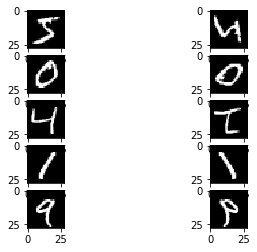

In [0]:
fig, ax = plt.subplots(5, 2) 
for i in range(5):
    ax[i][0].imshow(mnist[i][0], 'gray')
    ax[i][1].imshow(d4_transform(mnist[i][0]), 'gray')
plt.show()

## Data loaders

The main reason to implement `Dataset` class is a magic power of `torchvision` loaders:

The loaders are built on top of some dataset and allow batch iterating over it.

Those batches in their turn are created with applying the transformations defined in background processes.

Let's look at MNIST dataset with a simple transformer applied as loaders use tensors and not `PIL.Image`s.

In [0]:
transformed_mnist = MNIST('~/mnist/', train=True, transform=transforms.ToTensor())

In [0]:
mnist_loader = DataLoader(transformed_mnist, batch_size=16, shuffle=True, num_workers=16)  # shuffle note here

DataLoader standard parameter values are shown above.

One can also add **`pin_memory=True`** to page-lock the memory thus making faster cpu-to-cuda transfer with a non-blocking option.

**`drop_last=True`** is for avoiding batches size skew in the training process.

Let us demonstrate how it works:

In [0]:
for images, targets in tqdm(mnist_loader):
    pass

100%|██████████| 3750/3750 [00:04<00:00, 814.27it/s]


There are image batches as tensors on the output:

In [0]:
images.shape

torch.Size([16, 1, 28, 28])

In [0]:
targets.shape

torch.Size([16])

The loader instance pre-calculate the total number of batches (what makes `tqdm` happy):

In [0]:
len(mnist_loader)

3750

Some data example (will be random on each run):

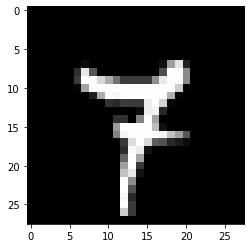

In [0]:
plt.imshow(images[0][0].numpy(), 'gray')
plt.show()

In [0]:
print(targets[0])

tensor(7)


## Building NN models

We should inherit `torch.nn.Module` class to implement pytorch model, `torch.nn` has lots of pre-defined "building bricks".

Their functional analogs are collected in `torch.nn.functional`.

We have both module and functional versions of max-pooling, activations, upsempling and some other ops:
* `nn.MaxPool2d` / `F.max_pool2d`
* `nn.ReLU` / `F.relu`
* `nn.Upsample(mode='bilinar')` / `F.upsample(mode='bilinar')` — **deprecated**, use `F.interpolate` instead

To compose several nn modules we can use `nn.Squential`:

In [0]:
layers = [
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU()
]
unet_down1 = nn.Sequential(*layers)
print(unet_down1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
)


## Models training

To train a model one must define a looss functions, some of them can also be found in `torch.nn`:

```python
output = model(torch.cat(x, 1))
target = torch.arange(1, 1001)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
```

We can update the weights manually:

```python
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
```

Or use built-in optimizer from `torch.optim` family:
```python
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)
```

We need to zero the gradients to disable gradient accumulations that happens by defult (`pytorch` sends its regards to `tf` rnn implementations):
```python
optimizer.zero_grad()
```

After zeroing the gradients we can run both forward and backward stage with loss calculation in-between:
```python
output = net(x)
loss = criterion(output, target)
loss.backward()
```

To update the weights we can use the optimizer again:
```python
optimizer.step()
```

To adjust learning rate in some pre-defined way we can use **`torch.optim.lr_scheduler`** sub-module:
```python
from torch.optim import lr_scheduler
```

To train ResNets on ImageNet with a standard training scheme we can use
```python
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(100):
    # no scheduler.step() here* 
    # train(...)
    # validate(...)
    scheduler.step()  # == scheduler.step(epoch)
```
\* one **should not** put `scheduler.step()` before `optimizer.step()`, otherwise the first epoch will be "skipped".

## Optional reading

There are several libraries out there like [`catalyst`](https://github.com/catalyst-team/catalyst) or [`kekas`](https://github.com/belskikh/kekas) that make building pipelines even easier.

# Pytorch in the wils

## Segmentation model creation (with U-Net as an example)

![U-Net scheme](https://github.com/pkorobov/deep-learning/blob/master/images/unet.png?raw=1)

Pre-defined heavily-used convolutions:

In [0]:
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

One **encoder block** consists of two sequential convolutions, an activation layer and an optional batch-norm:

In [0]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = batch_norm

        self.conv1 = conv3x3(in_channels, out_channels)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels)
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        return x

In [0]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [0]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


Alternative definition:

In [0]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.block = nn.Sequential()
        self.block.add_module('conv1', conv3x3(in_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn1', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu1', nn.ReLU())
        self.block.add_module('conv2', conv3x3(out_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn2', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu2', nn.ReLU())

    def forward(self, x):
        return self.block(x)

In [0]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (block): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
)

In [0]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


And its "functional" version:

In [0]:
def encoder_block(in_channels, out_channels, batch_norm=False):
    block = nn.Sequential()
    block.add_module('conv1', conv3x3(in_channels, out_channels))
    if batch_norm:
        block.add_module('bn1', nn.BatchNorm2d(out_channels))
    block.add_module('relu1', nn.ReLU())
    block.add_module('conv2', conv3x3(out_channels, out_channels))
    if batch_norm:
        block.add_module('bn2', nn.BatchNorm2d(out_channels))
    block.add_module('relu2', nn.ReLU())
    return block

In [0]:
block = encoder_block(3, 64)
block

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [0]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


Encoder is composed from several encoder blocks.

Its final form is defined bu the number of input channels, the number of channels in the first block output and the number of such blocks.

And we need to store preliminary activatons to apply Decoder on.

In [0]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks
        for i in range(num_blocks):
            in_channels = in_channels if not i else num_filters * 2 ** (i - 1)
            out_channels = num_filters * 2**i
            self.add_module(f'block{i + 1}', encoder_block(in_channels, out_channels))
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

Here we can use **`add_module`** way of layers definition as its number is variable.

In [0]:
encoder = Encoder(in_channels=3, num_filters=8, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (conv1): Conv2d(32, 64, kernel_s

In [0]:
x = torch.zeros(4, 3, 512, 512)

[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

Decoder block consists of upscaling "lower" output and concatenating it with a saved encoder block output from the "left".

In [0]:
Upsample = nn.Upsample

# class Upsample(nn.Module):
#     def __init__(self, scale_factor=2, mode='bilinear'):
#         super().__init__()

#         self.scale_factor = scale_factor
#         self.mode = mode

#     def forward(self, x):
#         return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=True)

class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.uppool = Upsample(scale_factor=2, mode='bilinear')
        self.upconv = conv3x3(out_channels * 2, out_channels)
        self.conv1 = conv3x3(out_channels * 2, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = torch.cat([left, x], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [0]:
block = DecoderBlock(8)

In [0]:
y = encoder(x)

In [0]:
y[1].shape, y[0].shape

(torch.Size([4, 16, 256, 256]), torch.Size([4, 8, 512, 512]))

In [0]:
block(y[1], y[0]).shape

/home/korobov/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([4, 8, 512, 512])

Let us build Decoder from several decoder blocks:

In [0]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [0]:
decoder = Decoder(8, 3)

In [0]:
x.shape

torch.Size([4, 3, 512, 512])

In [0]:
[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

In [0]:
decoder(encoder(x)).shape

torch.Size([4, 8, 512, 512])

U-Net is build from Encoder, Decoder and a final classification layer:

In [0]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=64, num_blocks=4):
        super().__init__()

        print(f'=> Building {num_blocks}-blocks {num_filters}-filter U-Net')

        self.encoder = Encoder(in_channels, num_filters, num_blocks)
        self.decoder = Decoder(num_filters, num_blocks - 1)
        self.final = nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

"Integration testing" (pytorch 0.3 legacy code):

In [0]:

model = UNet(num_classes=1)
if torch.cuda.is_available():
    model.cuda()

images = Variable(torch.randn(4, 3, 416, 416), volatile=True)
if torch.cuda.is_available():
    images = images.cuda()

model.forward(images).shape

=> Building 4-blocks 64-filter U-Net


/home/korobov/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


torch.Size([4, 1, 416, 416])

```
/home/nizhib/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
```

Same for **pytorch 0.4+**:

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(num_classes=1)
model.to(device)

images = torch.randn(4, 3, 416, 416).to(device)

with torch.no_grad():
    print(model.forward(images).shape)

=> Building 4-blocks 64-filter U-Net
torch.Size([4, 1, 416, 416])


We get linear activations as an output.

To train such models we need to use **/.\*WithLogits/** loss functions subset

We can use `torch.sigmoid` or `torch.softmax` to get probabilities (**0.4.1+**, `torch.nn.functional.sigmoid/softmax` before)

In [0]:
device

device(type='cuda')

## Using pretrained encoder

Encoder blocks structure seen before looks exactly like VGG architecture:

![img](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_vgg16.png)

Let us have a look at VGG model from `torchvision` library:

In [0]:
from torchvision.models import vgg13

VGG13 is the VGG version with 2 convolutional layer in each block:

In [0]:
model = vgg13()

In [0]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

We don't need the classifier, only the features are useful.

They are built from conv-relu-conv-relu + maxpooling.

Let's build encoder blocks via grouping VGG layers:

In [0]:
class VGG13Encoder(nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()

        backbone = vgg13(pretrained=pretrained).features

        self.num_blocks = num_blocks
        for i in range(self.num_blocks):
            block = nn.Sequential(*[backbone[j] for j in range(i * 5, i * 5 + 4)])
            self.add_module(f'block{i + 1}', block)

            if i == 0:
                for j in range(i * 5, i * 5 + 4):
                    print(backbone[j])

            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

In [0]:
vgg_encoder = VGG13Encoder(num_blocks=4, pretrained=False)
vgg_encoder

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)


VGG13Encoder(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequenti

Compare it to "vanilla" encoder:

In [0]:
encoder = Encoder(in_channels=3, num_filters=64, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (conv1): Conv2d(256, 

Both structures are identical!

But now we have some usefull pretrained weights in the decoder.

## <font color='#cc6666'>Hometask!</font>

### Part1. Toy dataset


**Implement** toy dataset to generate noisy ellipses like that:

![img](https://raw.githubusercontent.com/jakeret/tf_unet/master/docs/toy_problem.png)

The dataset should output both the image and its corresponding mask.

In [0]:
class Ellipses(Dataset):
    def __init__(self, sample_size=1000, transform=None, image_size=128, roll=False):
        
        self.background = np.array([[[15, 90, 110]]], np.uint8)
        self.colors = [(0, 150, 100), (200, 150, 100), (100, 150, 75), 
                       (50, 70, 100), (15, 100, 130), (190, 190, 90)]
        self.imgs = []
        self.transform = transform

        m = (0, 10, 10)
        s = (0, 15, 25)
        noise = np.zeros((image_size, image_size, 3), np.uint8)
        cv2.randn(noise, m, s)

        for i in range(sample_size):
            img = np.ones((image_size, image_size, 3), np.uint8) * self.background
            for j in range(18):
                cv2.circle(img, tuple(np.random.randint(image_size // 8, image_size - image_size // 8, size=2)), \
                           np.random.randint(3, 17), \
                           self.colors[np.random.randint(6)], cv2.FILLED)
            

            mask = (~np.all(img == self.background, axis=2)).astype(np.uint8) * 255
            img = cv2.add(img, noise)            
            self.imgs.append((img, mask))

    def __getitem__(self, index):
        img, mask = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask

    def __len__(self):
        return len(self.imgs)

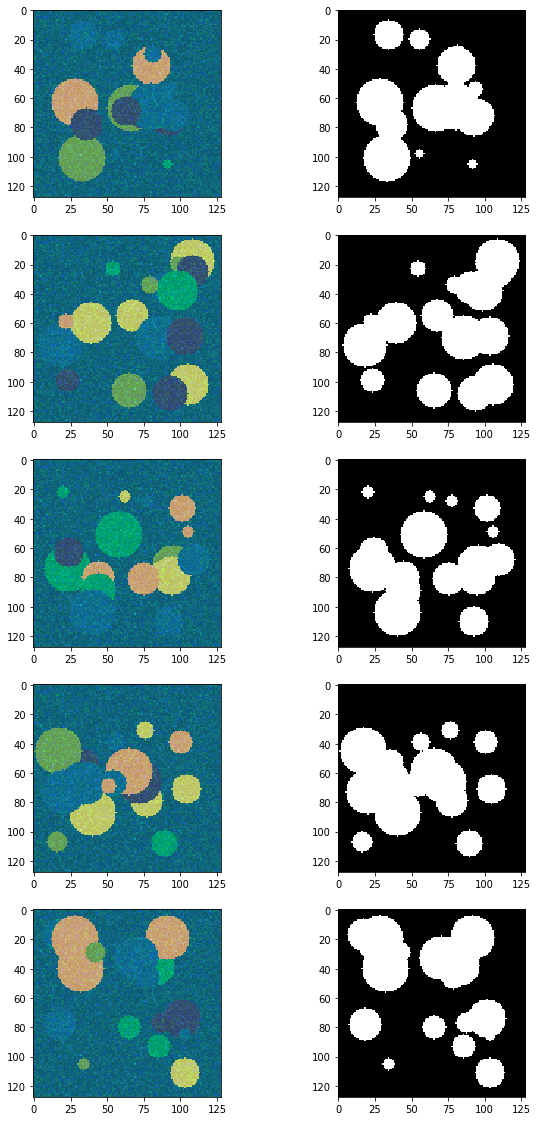

In [0]:
data = Ellipses(sample_size=5)
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    ax[i][0].imshow(data[i][0])
    ax[i][1].imshow(data[i][1], cmap='gray')

Define utility function:

In [0]:
import hashlib

def moy_variant(surname):
    return int(hashlib.md5(surname.encode().lower()).hexdigest()[-1], 16) % 2

In [0]:
moy_variant('korobov')

1

**Implement ACFNet** (https://arxiv.org/abs/1909.09408, if `moy_variant` returns 1 for you) **or OCRNet** (https://arxiv.org/abs/1909.11065, otherwise) based on pretrained **DenseNet** (pytorch) and **DPN** (cadene/pretrainedmodels) networks instead of ResNets from the papers.

It is advised to use `BCEWithLogitsLoss` as a loss function.

In [0]:
class ASPP(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(ASPP, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(in_channels, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(in_channels, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):

        feature_map_h = feature_map.size()[2]
        feature_map_w = feature_map.size()[3]

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) 
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) 
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map)))
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) 
        
        out_img = self.avg_pool(feature_map) 
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img)))
        out_img = F.interpolate(out_img, size=(feature_map_h, feature_map_w), mode="bilinear", align_corners=False) 

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) 
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out)))
        out = self.conv_1x1_4(out)

        return out

class ACFModule(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(ACFModule, self).__init__()

        self.num_classes = num_classes
        self.in_channels = in_channels
        
        self.conv_1x1_CCB = nn.Conv2d(in_channels, 512, kernel_size=1, stride=1, padding=0, dilation=1)
        self.conv_1x1_CAB = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, dilation=1)        
        self.conv_1x1_out = nn.Conv2d(in_channels + 512, 1, kernel_size=1, stride=1, padding=0, dilation=1)

    def forward(self, feature_map, coarse_seg):
        
        # CCB block
        feature_map_ = self.conv_1x1_CCB(feature_map)  
        feature_map_ = feature_map_.view(feature_map_.shape[0], feature_map_.shape[1], -1).permute(0, 2, 1) # l x HW x C'
        
        coarse_seg = coarse_seg.view(coarse_seg.shape[0], self.num_classes, -1) # shape: l x num_classes x HW 
        m = torch.einsum("bij,bjk->bik", coarse_seg, feature_map_)   # shape: l x num_classes x C'
        F_class = m / torch.sum(coarse_seg, axis=2, keepdim=True) 
        
        # CAB block
        F_a = torch.einsum("bij,bjk->bik", F_class.permute(0, 2, 1), coarse_seg) 
        F_a = F_a.view(F_a.shape[0], F_a.shape[1], feature_map.shape[2], feature_map.shape[3]) #shape: l x C' x H x W
        F_a = self.conv_1x1_CAB(F_a)
               
        out = torch.cat([F_a, feature_map], 1)
        out = self.conv_1x1_out(out)
        return out


In [0]:
class ACFDenseNet(nn.Module):
    def __init__(self, num_classes, backbone='densenet161'):
        super(ACFDenseNet, self).__init__()
        
        self.num_classes = num_classes
        
        # changing densenet structure
        model = densenet161(pretrained=True, memory_efficient=True).features
        for key, _ in model.denseblock3.named_children():
            getattr(model.denseblock3, key).conv2.padding=(2, 2)
            getattr(model.denseblock3, key).conv2.dilation=(2, 2)
        
        for key, _ in model.denseblock4.named_children():
            getattr(model.denseblock4, key).conv2.padding=(4, 4)
            getattr(model.denseblock4, key).conv2.dilation=(4, 4)
        model.transition2.pool = nn.Identity()
        model.transition3.pool = nn.Identity()         

        self.backbone = model
        self.aspp = ASPP(num_classes=1, in_channels=2208)
        self.acf = ACFModule(1, 2208)

    def forward(self, inp):
            
        fm = self.backbone(inp)
        fm = F.interpolate(fm, scale_factor=8, mode="bilinear", align_corners=False)
        
        coarse_seg_logit = self.aspp(fm)
        out = self.acf(fm, torch.sigmoid(coarse_seg_logit)) 
        return coarse_seg_logit, out
        
class ACFDPN(nn.Module):
    def __init__(self, num_classes, arch='dpn92'):
        super(ACFDPN, self).__init__()
        
        model = dpn92().features
        model.conv4_1.c3x3_b.conv.stride = (1, 1)
        model.conv4_1.c3x3_b.conv.dilation = (2, 2)
        model.conv4_1.c3x3_b.conv.padding = (2, 2)
        model.conv4_1.c1x1_w_s2.conv.stride = (1, 1)

        model.conv5_1.c3x3_b.conv.stride = (1, 1)
        model.conv5_1.c3x3_b.conv.dilation = (2, 2)
        model.conv5_1.c3x3_b.conv.padding = (2, 2)
        model.conv5_1.c1x1_w_s2.conv.stride = (1, 1)

        model.conv5_bn_ac.act = nn.Identity()
        
        self.backbone = model
        self.aspp = ASPP(num_classes=1, in_channels=2688)
        self.acf = ACFModule(1, 2688)

    def forward(self, inp):
        
        fm = self.backbone(inp)
        fm = F.interpolate(fm, scale_factor=8, mode="bilinear", align_corners=False)
        
        coarse_seg_logit = self.aspp(fm)
        out = self.acf(fm, torch.sigmoid(coarse_seg_logit)) 
        return coarse_seg_logit, out

In [0]:
def train_epoch(model, optimizer, train_loader):
    """
    for each batch 
    performs forward and backward pass and parameters update 
    
    Input:
    model: instance of model (example defined above)
    optimizer: instance of optimizer (defined above)
    train_loader: instance of DataLoader
    
    Returns:
    nothing
    
    Do not forget to set net to train mode!
    """
    

    model.train()
    for x_batch, y_batch in tqdm(train_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float() 
        
        optimizer.zero_grad()

        coarse_output, final_output = model(x_batch)
        loss = criterion(coarse_output, y_batch) * 0.35 + criterion(final_output, y_batch) * 0.65
        loss.backward()        
        optimizer.step()
    
    


def evaluate_loss_acc(loader, model):
    """
    Evaluates loss and accuracy on the whole dataset
    
    Input:
    loader:  instance of DataLoader
    model: instance of model (examle defined above)
    
    Returns: loss
    
    Do not forget to set net to eval mode!
    """

    model.eval()
    with torch.no_grad():
        cumloss, cumacc = 0, 0
        num_objects = 0
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)            
            _, output = model(x_batch)
            loss = criterion(output, y_batch)

            cumloss += loss.item()
            num_objects += len(x_batch)

        return cumloss / num_objects
    
def train(model, opt, train_loader, test_loader, n_epochs, scheduler, logger, verbose=True):
    """
    Performs training of the model and prints progress
    
    Input:
    model: instance of model (example defined above)
    opt: instance of optimizer 
    train_loader: instance of DataLoader
    test_loader: instance of DataLoader (for evaluation)
    n_epochs: int
    
    Returns:
    2 lists: train_log, val_log
    """
        
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    img_to_paint, masks_to_paint = next(iter(test_loader))
    img_to_paint = img_to_paint.to(device)
    masks_to_paint = masks_to_paint.to(device)
    
    for epoch in tqdm(range(n_epochs)):
        train_epoch(model, opt, train_loader)
        

        train_loss = evaluate_loss_acc(train_loader, model)
        val_loss = evaluate_loss_acc(test_loader, model)
        scheduler.step(train_loss)
        
        out_to_paint = model.forward(img_to_paint)[1]                
        with torch.no_grad():
            logger.add_image('Evolution of the first batch', \
                torch.cat([make_grid(img_to_paint), \
                make_grid(masks_to_paint),  \
                make_grid(torch.sigmoid(out_to_paint).round())], 1), epoch + 1)
            logger.add_scalar('data/train_loss', train_loss, epoch + 1)
            logger.add_scalar('data/val_loss', val_loss, epoch + 1)

        train_log.append(train_loss)
        val_log.append(val_loss)
        
        if verbose:
              print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f') \
                    %(epoch+1, n_epochs, train_loss, val_loss))
           
    return train_log, val_log

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 0.001
criterion = BCEWithLogitsLoss()

set_global_seed(SEED)
train_data = Ellipses(200, transform=transforms.ToTensor())
test_data = Ellipses(50, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=4)
test_loader = DataLoader(test_data, batch_size=4)

In [0]:
acf_densenet = ACFDenseNet(num_classes=1).to(device)
optimizer = torch.optim.Adam(acf_densenet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, verbose=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 66.1MB/s]


In [0]:
%%time

logger = SummaryWriter(comment="ACFDenseNet")
train(acf_densenet, optimizer, train_loader, test_loader, 20, scheduler, logger)
logger.close()


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/20], Loss (train/test): 0.0211/0.0241



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/20], Loss (train/test): 0.0133/0.0159



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/20], Loss (train/test): 0.0147/0.0181



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/20], Loss (train/test): 0.0189/0.0220



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/20], Loss (train/test): 0.0109/0.0132



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/20], Loss (train/test): 0.0111/0.0142



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/20], Loss (train/test): 0.0109/0.0135



100%|██████████| 50/50 [04:29<00:00,  5.37s/it]


Epoch     7: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/20], Loss (train/test): 0.0121/0.0150



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/20], Loss (train/test): 0.0088/0.0111



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/20], Loss (train/test): 0.0082/0.0107



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/20], Loss (train/test): 0.0079/0.0105



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/20], Loss (train/test): 0.0076/0.0104



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/20], Loss (train/test): 0.0073/0.0103



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/20], Loss (train/test): 0.0071/0.0102



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/20], Loss (train/test): 0.0068/0.0101



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/20], Loss (train/test): 0.0066/0.0101



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/20], Loss (train/test): 0.0064/0.0101



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/20], Loss (train/test): 0.0062/0.0101



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/20], Loss (train/test): 0.0060/0.0102



100%|██████████| 20/20 [2:04:25<00:00, 372.64s/it]

Epoch [20/20], Loss (train/test): 0.0059/0.0103
CPU times: user 1h 11min, sys: 53min 13s, total: 2h 4min 13s
Wall time: 2h 4min 25s


In [0]:
acf_dpn = ACFDPN(num_classes=1).to(device)
optimizer = torch.optim.Adam(acf_dpn.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, verbose=True)

In [0]:
%%time

logger = SummaryWriter(comment="ACFDPN")
train(acf_dpn, optimizer, train_loader, test_loader, 20, scheduler, logger)
logger.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/20], Loss (train/test): 0.0312/0.0396



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/20], Loss (train/test): 0.0162/0.0192



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/20], Loss (train/test): 0.0133/0.0158



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/20], Loss (train/test): 0.0131/0.0173



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/20], Loss (train/test): 0.0162/0.0221



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/20], Loss (train/test): 0.0134/0.0159



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/20], Loss (train/test): 0.0104/0.0133



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/20], Loss (train/test): 0.0130/0.0156



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/20], Loss (train/test): 0.0119/0.0137



100%|██████████| 50/50 [05:25<00:00,  6.50s/it]


Epoch     9: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/20], Loss (train/test): 0.0198/0.0249



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/20], Loss (train/test): 0.0090/0.0110



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/20], Loss (train/test): 0.0080/0.0103



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/20], Loss (train/test): 0.0075/0.0101



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/20], Loss (train/test): 0.0072/0.0099



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/20], Loss (train/test): 0.0069/0.0099



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/20], Loss (train/test): 0.0067/0.0098



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/20], Loss (train/test): 0.0065/0.0098



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/20], Loss (train/test): 0.0063/0.0097



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/20], Loss (train/test): 0.0062/0.0097



100%|██████████| 20/20 [2:29:08<00:00, 447.42s/it]

Epoch [20/20], Loss (train/test): 0.0060/0.0097
CPU times: user 1h 25min 24s, sys: 1h 3min 34s, total: 2h 28min 59s
Wall time: 2h 29min 8s


**Demonstrate** how they are trained with `tensorboard` screenshots (use `tensorboardX` library).

That includes but not limited to loss curves, masks from different epochs etc.

### Part2. Portrait Segmentation

Repeat the training procedures on some real task: http://xiaoyongshen.me/webpage_portrait/.

Easy-to-use dataset version can be downloaded from https://yadi.sk/d/1SSkfLh4WnEhmw.

Use `dice score` as a target scoring function, it should be published in the final report.

All the loss charts, mask quality evolution and final mask examples are expected as well.

In [0]:
from pathlib import Path

ROOT = Path("APSIS")
images_path = ROOT / "images"
masks_path = ROOT / "masks"

ALL_IMAGES = sorted(images_path.glob("*.jpg"))
ALL_MASKS = sorted(masks_path.glob("*.png"))

In [0]:
SEED = 111
set_global_seed(SEED)
prepare_cudnn(deterministic=True)

In [0]:
H = 160 # size divisible by 8
W = 120

PRE_TRANSFORM = Resize(H, W)
AUGMENTATIONS = Compose(
    [
        HorizontalFlip(p = 0.5),
        OneOf(
            [
                RandomContrast(),
                RandomBrightness(),
                HueSaturationValue(),
                RGBShift(),
            ],
            p = 1
        ),
        RandomSizedCrop(min_max_height=(H - H // 6, H), w2h_ratio = W / H, height=H, width=W, p=0.3),
        ShiftScaleRotate(
            shift_limit=0.01, 
            scale_limit=(0.05, 0.2),
            rotate_limit=15,
            p=0.4,
            border_mode=cv2.BORDER_CONSTANT
        )
    ]
)
POST_TRANSFORM = Compose(
    [
        ToTensor()    
    ]
)


class APSIS(Dataset):
    def __init__(self, images, masks, transform=None):
        
        self.images = images
        self.masks = masks
        self.transform = transform
       
    def __getitem__(self, index):
                
        image_path = self.images[index]
        mask_path = self.masks[index]
        
        image = utils.imread(image_path)
        mask = utils.imread(mask_path)
        
                
        if self.transform is not None:
            aug_result = self.transform(image=image, mask=mask[:,:,0])
            image = aug_result['image']
            mask = aug_result['mask']
        return image, mask

    def __len__(self):
        return len(self.images)

In [0]:
dataset = APSIS(ALL_IMAGES, ALL_MASKS, transform=Compose([PRE_TRANSFORM, AUGMENTATIONS, POST_TRANSFORM]))

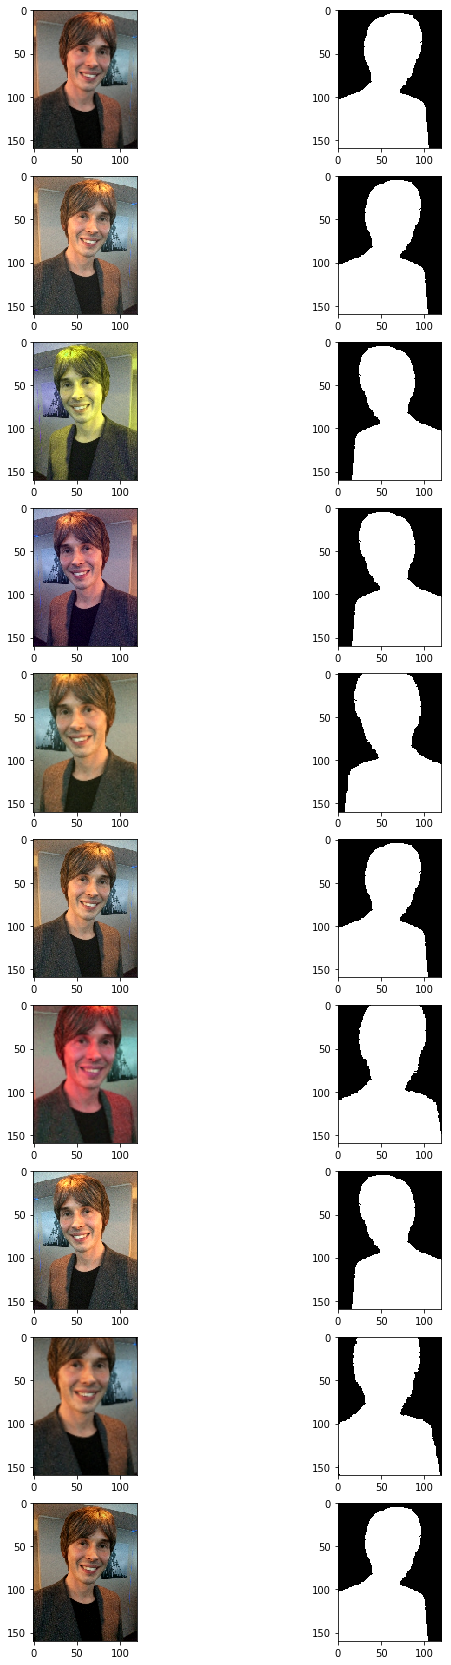

In [25]:
# let's look at augmentation results

fig, ax = plt.subplots(10, 2, figsize=(10, 30))
for i in range(10):
    img, mask = dataset[0]
    ax[i, 0].imshow(img.permute(1, 2, 0).detach())
    ax[i, 1].imshow(mask[0].detach(), cmap='gray')

In [0]:
def get_loaders(images, masks, random_state, valid_size = 0.2,
                batch_size = 4, num_workers = 4, train_transforms_fn = None,
                valid_transforms_fn = None):

    indices = np.arange(len(images))
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    train_dataset = APSIS(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transform = Compose([PRE_TRANSFORM, AUGMENTATIONS, POST_TRANSFORM])
     )

    valid_dataset = APSIS(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transform = Compose([PRE_TRANSFORM, POST_TRANSFORM])
    )

    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers
    )

    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [0]:
batch_size = 4
num_epochs = 10

In [0]:
from catalyst.dl.callbacks.logging import TensorboardLogger
from catalyst.dl.core import Callback, RunnerState, CallbackOrder

device = torch.device('cuda')


class MaskLogger(TensorboardLogger):
 
    def __init__(self):
        super().__init__(CallbackOrder.Logger)
        self.loggers = {"mask_log": SummaryWriter("Mask_evolution",  log_dir="Masks")}
        
    def _log_masks(self, step: int, model, suffix=""):
                
        model.eval()
        predictions = model.forward(IMAGES_TO_PAINT)[1]
        with torch.no_grad():
            self.loggers['mask_log'].add_image(f"Masks{suffix}", \
                torch.cat([make_grid(IMAGES_TO_PAINT), \
                           make_grid(MASKS_TO_PAINT),  \
                           make_grid(torch.sigmoid(predictions).round()) \
                          ], 1), step + 1)
        print(self.loggers) 
      
    def on_batch_end(self, state: RunnerState):
        pass
        
    def on_loader_end(self, state: RunnerState):

        model = state.model

        self._log_masks(
            model=model, step=state.epoch, suffix="/epoch"
        )

        for logger in self.loggers.values():
            logger.flush()
            
loaders = get_loaders(ALL_IMAGES[:100], ALL_MASKS[:100], 111, valid_size = 0.2,
                      batch_size = batch_size, num_workers = 2, train_transforms_fn = None,
                      valid_transforms_fn = None)

IMAGES_TO_PAINT, MASKS_TO_PAINT = next(iter(loaders['valid']))
IMAGES_TO_PAINT, MASKS_TO_PAINT = IMAGES_TO_PAINT.to(device), MASKS_TO_PAINT.to(device)

In [0]:
runner = SupervisedRunner(device=device, input_key="image", output_key=("coarse_logits", "logits"), input_target_key="mask")

In [0]:
def train_model(model):

    acf_densenet = model.to(device)
    optimizer = torch.optim.Adam(acf_densenet.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, verbose=True)

    criterion = {
        "dice": DiceLoss(), 
    }

    set_global_seed(SEED)
    runner.train(
        model=acf_densenet,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,

        loaders=loaders,

        callbacks=[
            MaskLogger(),

            CriterionCallback(
                input_key="mask",
                output_key="logits",
                prefix="loss_dice",
                criterion_key="dice",
            ),

            CriterionCallback(
                input_key="mask",
                output_key="coarse_logits",
                prefix="loss_dice_coarse",
                criterion_key="dice",
                multiplier=0.5
            ),

            CriterionAggregatorCallback(
                prefix="loss",
                loss_keys=["loss_dice", "loss_dice_coarse"],
                loss_aggregate_fn="sum"
            ),

            DiceCallback(input_key="mask", output_key='coarse_logits', prefix='coarse_dice'),
            DiceCallback(input_key='mask', output_key='logits', prefix='dice')
        ],
        logdir='runs',    
        num_epochs=num_epochs,

        main_metric="loss_dice",
        minimize_metric=False,
        verbose=True
    )

In [47]:
train_model(ACFDenseNet(num_classes=1))

0/10 * Epoch (train): 100% 20/20 [04:03<00:00, 11.95s/it, _timers/_fps=2.612, coarse_dice=0.913, dice=0.926, loss=0.118, loss_dice=0.074, loss_dice_coarse=0.044]{'mask_log': <tensorboardX.writer.SummaryWriter object at 0x7f78bb2f7d30>, 'train': <tensorboardX.writer.SummaryWriter object at 0x7f78bb2ec9b0>}

0/10 * Epoch (valid): 100% 5/5 [00:09<00:00,  1.96s/it, _timers/_fps=2.596, coarse_dice=0.886, dice=0.914, loss=0.142, loss_dice=0.086, loss_dice_coarse=0.057]{'mask_log': <tensorboardX.writer.SummaryWriter object at 0x7f78bb2f7d30>, 'train': <tensorboardX.writer.SummaryWriter object at 0x7f78bb2ec9b0>, 'valid': <tensorboardX.writer.SummaryWriter object at 0x7f78bb2ecef0>}

[2019-10-22 18:36:06,884] 
0/10 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=2.5015 | _timers/batch_time=1.7184 | _timers/data_time=0.1723 | _timers/model_time=1.5460 | coarse_dice=0.8468 | dice=0.8706 | loss=0.2059 | loss_dice=0.1294 | loss_dice_coarse=0.0766
0/10 * Epoch 0 (valid): _

In [0]:
%tensorboard --logdir ACFDenseNet_runs

In [32]:
train_model(ACFDPN(num_classes=1))

0/10 * Epoch (train): 100% 20/20 [05:22<00:00, 14.33s/it, _timers/_fps=2.157, coarse_dice=0.886, dice=0.899, loss=0.158, loss_dice=0.101, loss_dice_coarse=0.057]{'mask_log': <tensorboardX.writer.SummaryWriter object at 0x7f3840225da0>, 'train': <tensorboardX.writer.SummaryWriter object at 0x7f38402000f0>}

0/10 * Epoch (valid): 100% 5/5 [00:11<00:00,  2.33s/it, _timers/_fps=2.165, coarse_dice=0.017, dice=0.133, loss=1.358, loss_dice=0.867, loss_dice_coarse=0.491]{'mask_log': <tensorboardX.writer.SummaryWriter object at 0x7f3840225da0>, 'train': <tensorboardX.writer.SummaryWriter object at 0x7f38402000f0>, 'valid': <tensorboardX.writer.SummaryWriter object at 0x7f3840200198>}

[2019-10-22 19:55:32,661] 
0/10 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=2.0823 | _timers/batch_time=2.5438 | _timers/data_time=0.0163 | _timers/model_time=2.5275 | coarse_dice=0.8125 | dice=0.8373 | loss=0.2565 | loss_dice=0.1627 | loss_dice_coarse=0.0937
0/10 * Epoch 0 (valid): _

### Finally, we can see, that the first model (ACFDenseNet) has greater perfomance in both cases and becomes capable of producing acceptable results earlier.

### Part 3. Bells and whistles

* Use at least 5 `albumentations` or `imgaug` augmentations on the data preparation step (up to 0.5 bonus points);


* Use `catalyst` or `kekas` to build the training pipeline (up to 0.5 bonus points);


* Deploy the web demo to play with on your own `dl2019fall-{lastname}.ml` domain.

  The demo earns 0.1 bonus points for each day it's alive in the range from **Oct 14 00:00 to Oct 27 23:59**.

  You can use https://github.com/nizhib/portrait-demo as a start point (up to 2 bonus points for 2-week streak).